In [44]:
from sklearn.datasets import make_classification, make_moons
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score, roc_curve, roc_auc_score

from scipy.stats import pearsonr, spearmanr

In [2]:
def interval_transform(x, a, b):
    m = x.min()
    ma = x.max()
    
    alpha_inv = (1 - m/ma)*ma/(a - b)
    alpha = 1/alpha_inv
    beta = b - alpha*m
    
    f = lambda x: alpha*x + beta 
    return f(x)

def make_noise_feature(x):
    n_features = x.shape[1]
    n_samples = x.shape[0]
    
    weights = np.random.uniform(1e-4, 1e-2, n_features)
    noise = np.random.normal(1, 5, n_samples)
    signal = np.sum(weights*x, -1) 
    return signal + noise

def calculate_pvalues(df,
                      method = spearmanr
                     ):
    """
    Assumes df with only numeric entries clean of null entries. 
    """
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(method(df[r], df[c])[1], 4)
    return pvalues

def correlation_matrix(df,
                       method = "pearson",
                       annot_bool = False,
                       annot_size = 20
                      ):
    # Compute the correlation matrix
    corr = df.corr(method = method)

    if annot_bool:
        annot = corr.copy()
        
        if method == "pearson":
            sig_meth = pearsonr
        else:
            sig_meth = spearmanr
            
        pval = calculate_pvalues(df, sig_meth) 
        # create three masks
        r0 = corr.applymap(lambda x: '{:.2f}'.format(x))
        r1 = corr.applymap(lambda x: '{:.2f}*'.format(x))
        r2 = corr.applymap(lambda x: '{:.2f}**'.format(x))
        r3 = corr.applymap(lambda x: '{:.2f}***'.format(x))
  
        # apply them where appropriate --this could be a single liner
        annot = annot.where(pval>0.1,r0)
        annot = annot.where(pval<=0.1,r1)
        annot = annot.where(pval<=0.05,r2)
        annot = annot.mask(pval<=0.01,r3)

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 11))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5},
                annot = annot,
                fmt = "",
                annot_kws={"size": annot_size},
                vmin = -1,
                vmax = 1,
               )

In [3]:
n_info = 3
n_redu = 0
n_samples=2000

#making nonlinear decision boundaries requires multiple blob like features 
X1, y1 = make_classification(
        n_samples=n_samples,
        n_features=3,
        n_informative=n_info,
        n_redundant=n_redu,
        n_clusters_per_class=2,
        shuffle=False,
        random_state=42, 
        #difficulty
        flip_y=0.05,
        class_sep=.7,
        weights=[0.6, 0.4]
        )

X2, y2 = make_classification(
        n_samples=n_samples,
        n_features=3,
        n_informative=n_info,
        n_redundant=n_redu,
        n_clusters_per_class=4,
        shuffle=False,
        random_state=6, 
        #difficulty
        flip_y=0.05,
        class_sep=0.6,
        weights=[0.7, 0.3],
        )

X3, y3 = make_moons(n_samples=2*n_samples, noise=1, random_state=42)

X = np.concatenate([X1, X2], axis=0)
y = np.concatenate([y1, y2], axis=0)

data = np.concatenate([X, np.expand_dims(y, -1)], -1)
data = pd.DataFrame(data)

In [4]:
print(X.shape)

(4000, 3)


In [5]:
data.head()

,0,1,2,3
0,0.624252,-0.763530,1.845129,0.0
1,0.476661,-0.756538,0.471304,0.0
2,-0.796419,-0.467533,0.883130,0.0
3,-2.589894,0.382227,0.425489,0.0
4,-2.402330,-0.491994,0.713940,0.0


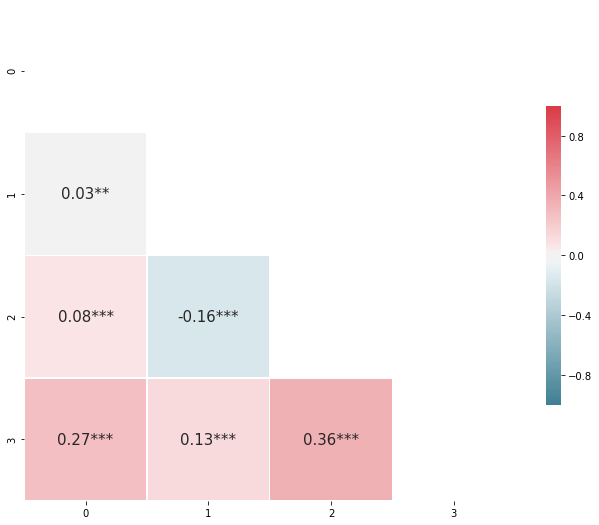

In [6]:
correlation_matrix(data, annot_bool=True, annot_size=15)

(array([2569.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1431.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

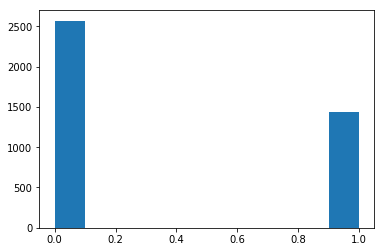

In [7]:
plt.hist(y)

To educationify the data we scale and transform the dataset:

For the informative features we'll use:
* GPA [0, 4] unit:grade
* Attendance [0, 100] unit:percent
* Passed percent of classes [0, 100] unit:percent

For the redundant we'll use: 
* Sex [0, 1] unit:integer class
* Ethnicity [0, 1, 2] unit:integer class
* HSGPA [0, 4] unit:grade


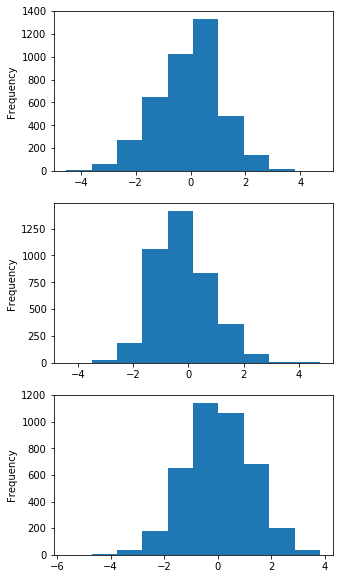

In [8]:
fig, axs = plt.subplots(nrows=n_info, figsize=(5, 10 ))
for i in range(n_info):
    ax = axs[i]
    data[i].plot(kind="hist", ax=ax)

(array([3.300e+01, 2.040e+02, 6.810e+02, 1.070e+03, 1.145e+03, 6.490e+02,
        1.790e+02, 3.500e+01, 3.000e+00, 1.000e+00]),
 array([-1.42108547e-14,  1.00000000e+01,  2.00000000e+01,  3.00000000e+01,
         4.00000000e+01,  5.00000000e+01,  6.00000000e+01,  7.00000000e+01,
         8.00000000e+01,  9.00000000e+01,  1.00000000e+02]),
 <a list of 10 Patch objects>)

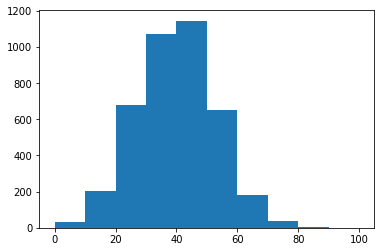

In [9]:
attendance_column = interval_transform(data[2], 0, 100)
plt.hist(attendance_column)

(array([   6.,    8.,   86.,  362.,  837., 1417., 1063.,  189.,   29.,
           3.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <a list of 10 Patch objects>)

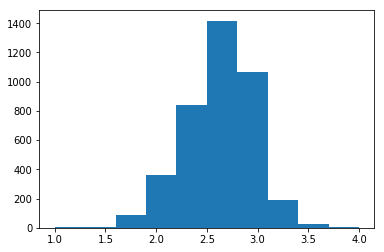

In [10]:
gpa_column = interval_transform(data[1], 1, 4) 
plt.hist(gpa_column)

(array([   4.,   17.,  141.,  483., 1331., 1026.,  650.,  276.,   65.,
           7.]),
 array([-7.10542736e-15,  1.00000000e+01,  2.00000000e+01,  3.00000000e+01,
         4.00000000e+01,  5.00000000e+01,  6.00000000e+01,  7.00000000e+01,
         8.00000000e+01,  9.00000000e+01,  1.00000000e+02]),
 <a list of 10 Patch objects>)

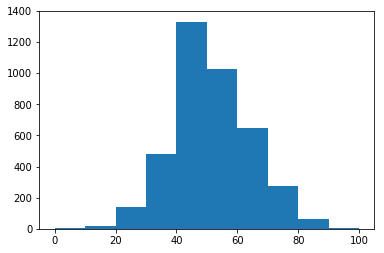

In [11]:
passed_column = interval_transform(data[0], 0, 100)
plt.hist(passed_column)

(array([2008.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1992.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

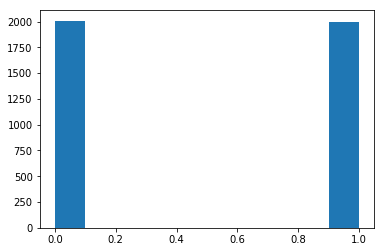

In [12]:
sex_column = make_noise_feature(X)
sex_column = (sex_column > sex_column.mean()).astype(int)
plt.hist(sex_column)

(array([   9.,   48.,  215.,  532.,  816., 1039.,  788.,  368.,  157.,
          28.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

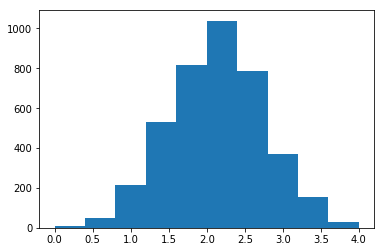

In [13]:
hsgpa_column = interval_transform(make_noise_feature(X), 0, 4)
plt.hist(hsgpa_column)

(array([1000.,    0.,    0.,    0.,    0., 1000.,    0.,    0.,    0.,
        2000.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

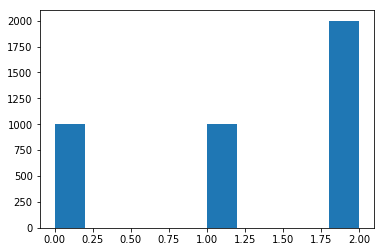

In [14]:
ethn_column = make_noise_feature(X)
ethn_column = pd.qcut(ethn_column, q=[0, .25, .5, 1], labels=[0, 1, 2])
plt.hist(ethn_column)

In [15]:
gpa_column.shape

(4000,)

In [16]:
full_data = np.concatenate(
                [
                    np.expand_dims(gpa_column, axis=-1),
                    np.expand_dims(attendance_column, axis=-1),
                    np.expand_dims(passed_column, axis=-1),
                    np.expand_dims(sex_column, axis=-1),
                    np.expand_dims(hsgpa_column, axis=-1),
                    np.expand_dims(ethn_column, axis=-1),
                    np.expand_dims(y, axis=-1)
                ],
                axis=1
)

columns = [              
           "cGPA",
           "attendance",
           "passed_percent",
           "sex",
           "hsGPA",
           "ethnicity",
           "passed_course"]

df_full = pd.DataFrame(full_data,
                       columns=columns)

In [17]:
df_full.head()

,cGPA,attendance,passed_percent,sex,hsGPA,ethnicity,passed_course
0,2.804237,20.729776,44.264054,0.0,1.925467,2.0,0.0
1,2.801956,35.256924,45.859841,1.0,1.497950,2.0,0.0
2,2.707675,30.902179,59.624675,0.0,2.407627,0.0,0.0
3,2.430461,35.741390,79.016129,1.0,2.574542,0.0,0.0
4,2.715655,32.691236,76.988142,0.0,2.129951,2.0,0.0


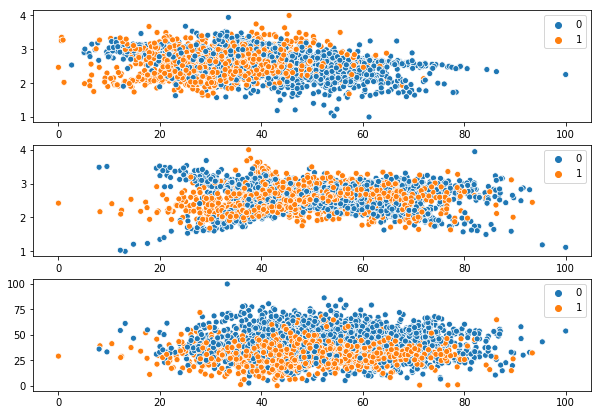

In [18]:
comb = [(1, 0), (2, 0), (2, 1)]
fig, axs = plt.subplots(nrows=len(comb), figsize=(10, 7))

for i in range(len(comb)):
    sns.scatterplot(full_data[:,comb[i][0]], full_data[:,comb[i][1]], hue=y, ax=axs[i])

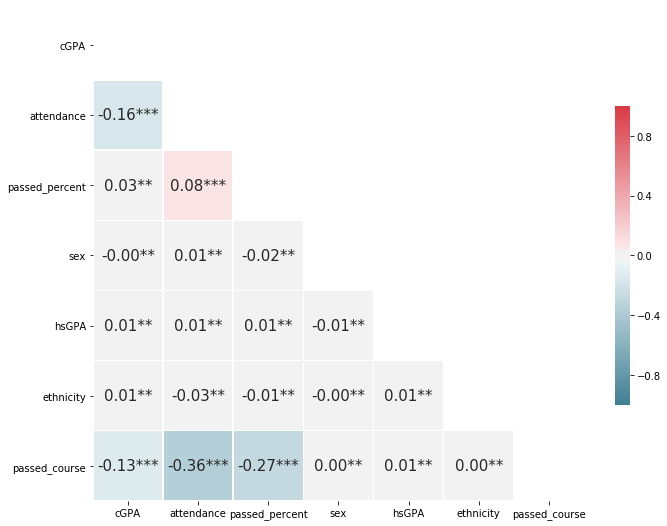

In [19]:
correlation_matrix(df_full, annot_bool=True, annot_size=15)

In [35]:
t_X = X.copy()
fd = full_data[:, :-1].copy()

for i in range(t_X.shape[1]):
    t_X[:,i] = (t_X[:,i] - t_X[:,i].mean())/t_X[:,i].std()
    
for i in [0, 1, 2, -1]:
    fd[:,i] = (fd[:,i] - fd[:,i].mean())/fd[:,i].std()

    
data_c = [c for c in columns if c != "passed_course"]
clf_data = df_full[data_c].values
clf_targets = df_full["passed_course"].values

#x_train, x_test, y_train, y_test = train_test_split(t_X, y, shuffle=True)
x_train, x_test, y_train, y_test = train_test_split(fd, full_data[:,-1], shuffle=True)

In [45]:
model = LogisticRegression(class_weight="balanced", solver="lbfgs")
model.fit(x_train, y_train)

mlp_model = MLPClassifier(
                activation="tanh",
                hidden_layer_sizes=[100, ]*20,
                max_iter=1000,
                early_stopping=True,
                validation_fraction=0.2,
                alpha=0.1,
                beta_1=0.8,
                learning_rate_init=0.0001
                )

mlp_model.fit(x_train, y_train)

rf_model = RandomForestClassifier()
rf_model.fit(x_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [47]:
print("LR model", f1_score(y_test, model.predict(x_test)))
print("MLP model", f1_score(y_test, mlp_model.predict(x_test)))
print("RF model", f1_score(y_test, rf_model.predict(x_test)))

LR model 0.6082191780821917
MLP model 0.5703422053231939
RF model 0.6539130434782608


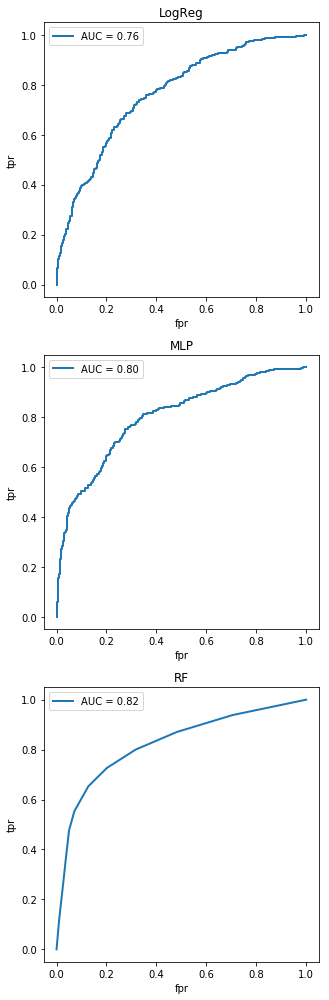

In [50]:
models = [model, mlp_model, rf_model]
names = ["LogReg", "MLP", "RF"]
fig, axs = plt.subplots(nrows=len(models), figsize=(14, 14))

for i in range(len(models)):
    ax = axs[i]
    m = models[i]
    name = names[i]
    
    try:
        pred = m.predict_proba(x_test)
    except:
        pred = m.predict(x_test)
    
    fpr, tpr, _= roc_curve(y_test, pred[:,1], pos_label=1)
    ax.set_title(name)
    ax.plot(
        fpr,
        tpr,
        label="AUC = {:.2f}".format(roc_auc_score(y_test, pred[:,1])),
        linewidth=2
    )
    
    ax.set_xlabel("fpr")
    ax.set_ylabel("tpr")
    ax.set_aspect("equal")
    ax.legend()
    
plt.tight_layout()